<a href="https://colab.research.google.com/github/nivagithub/online-payment-Fraud-detection/blob/main/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import itertools
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression

# New Section

In [4]:
dataframe = pd.read_csv("/content/drive/MyDrive/onlinefraud.csv")
dataframe.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
dataframe.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
# Check for null values

dataframe.isnull().values.any()


False

In [7]:
dataframe["amount"].describe()



,amount
count,6.362620e+06
mean,1.798619e+05
std,6.038582e+05
min,0.000000e+00
25%,1.338957e+04
50%,7.487194e+04
75%,2.087215e+05
max,9.244552e+07


In [8]:
# distribution of legit transactions & fraudulent transactions
dataframe['isFraud'].value_counts()

,count
isFraud,
0,6354407
1,8213


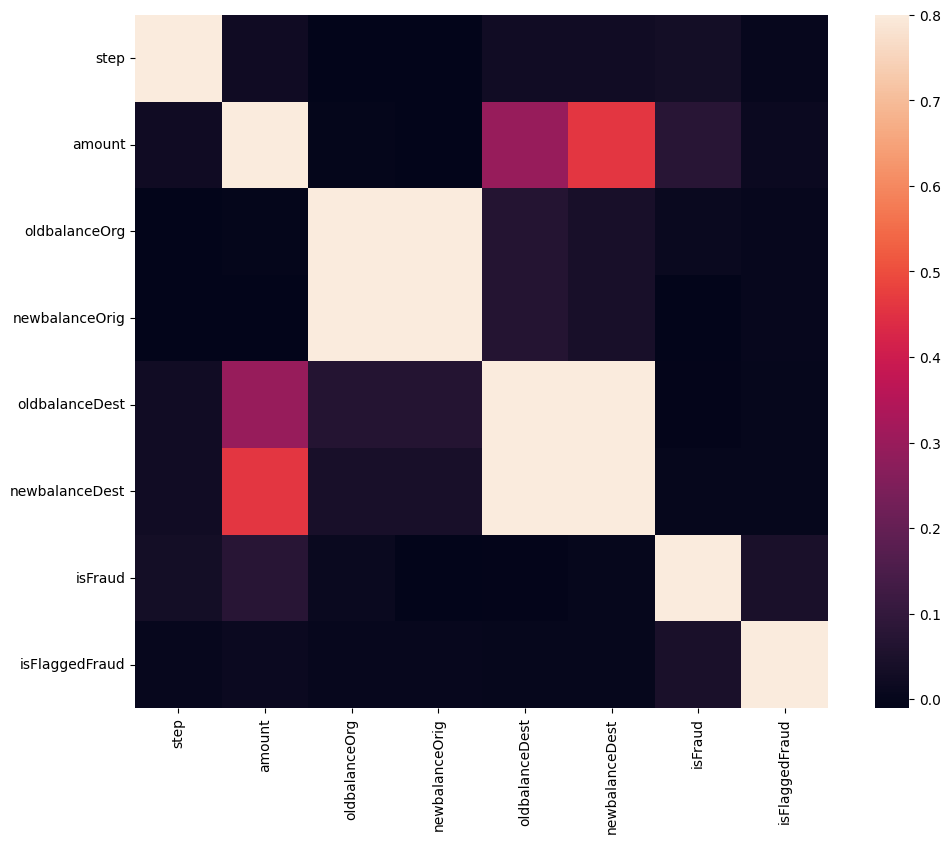

In [59]:
# Correlation matrix
# Select only numerical features for correlation analysis
numerical_features = dataframe.select_dtypes(include=np.number).columns
corrmat = dataframe[numerical_features].corr()

fig = plt.figure(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8,square = True)
plt.show()

In [10]:
# separating the data for analysis
legit = dataframe[dataframe.isFraud == 0]
fraud = dataframe[dataframe.isFraud == 1]

In [11]:
print(legit.shape)
print(fraud.shape)


(6354407, 11)
(8213, 11)


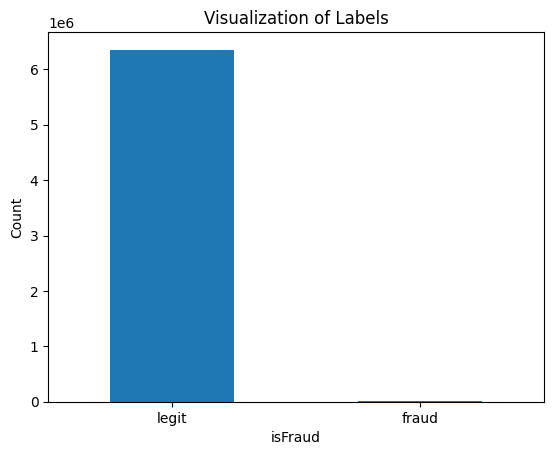

In [12]:
# Visualize the "Labels" column in our dataset

labels = ["legit", "fraud"]
count_classes = dataframe.value_counts(dataframe['isFraud'], sort= True)
count_classes.plot(kind = "bar", rot = 0)
plt.title("Visualization of Labels")
plt.ylabel("Count")
plt.xticks(range(2), labels)
plt.show()

In [13]:
# statistical measures of the data
legit.amount.describe()

,amount
count,6.354407e+06
mean,1.781970e+05
std,5.962370e+05
min,1.000000e-02
25%,1.336840e+04
50%,7.468472e+04
75%,2.083648e+05
max,9.244552e+07


In [14]:
fraud.amount.describe()

,amount
count,8.213000e+03
mean,1.467967e+06
std,2.404253e+06
min,0.000000e+00
25%,1.270913e+05
50%,4.414234e+05
75%,1.517771e+06
max,1.000000e+07


Under-Sampling

Build a sample dataset containing similar distribution of normal transactions and Fraudulent Transaction

Concating two DataFrames



In [15]:
legit_sample = legit.sample(n=492)
new_dataset = pd.concat([legit_sample, fraud], axis=0)

In [16]:
new_dataset.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3027499,233,CASH_OUT,44902.33,C2126636561,0.0,0.00,C1640153538,80049.29,124951.62,0,0
3835969,282,CASH_OUT,136389.08,C103744712,40174.0,0.00,C724836331,0.00,136389.08,0,0
6167157,552,CASH_IN,10244.80,C873525374,267149.0,277393.80,C618227526,87498.92,77254.12,0,0
5790890,401,CASH_OUT,458063.75,C1919226456,0.0,0.00,C291498818,10459836.91,10917900.66,0,0
4472764,324,CASH_IN,406992.18,C1806689398,53443.0,460435.18,C924326705,11768441.64,11361449.47,0,0


In [17]:
new_dataset.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [18]:
new_dataset['isFraud'].value_counts()

,count
isFraud,
1,8213
0,492


In [20]:
new_dataset.groupby('isFraud').mean(numeric_only=True)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
isFraud,,,,,,,
0,241.894309,1.533797e+05,8.698582e+05,894690.520224,1.128798e+06,1.222543e+06,0.000000
1,368.413856,1.467967e+06,1.649668e+06,192392.631836,5.442496e+05,1.279708e+06,0.001948


In [21]:
X = new_dataset.drop(columns='isFraud', axis=1)
Y = new_dataset['isFraud']
print(X)

         step      type      amount     nameOrig  oldbalanceOrg  \
3027499   233  CASH_OUT    44902.33  C2126636561           0.00   
3835969   282  CASH_OUT   136389.08   C103744712       40174.00   
6167157   552   CASH_IN    10244.80   C873525374      267149.00   
5790890   401  CASH_OUT   458063.75  C1919226456           0.00   
4472764   324   CASH_IN   406992.18  C1806689398       53443.00   
...       ...       ...         ...          ...            ...   
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  \
3027499            0.00  C1640153538        80049.29       124951.62   
3835969            0.00   C724836331            0.0

In [22]:
print(Y)

3027499    0
3835969    0
6167157    0
5790890    0
4472764    0
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: isFraud, Length: 8705, dtype: int64


In [23]:
# Split the data
(train_X, test_X, train_Y, test_Y) = train_test_split(X, Y, test_size= 0.3, random_state= 42)

print("Shape of train_X: ", train_X.shape)
print("Shape of test_X: ", test_X.shape)
print("shape of train_y:",train_Y.shape)
print("shape of test_Y: ", test_Y.shape)


Shape of train_X:  (6093, 10)
Shape of test_X:  (2612, 10)
shape of train_y: (6093,)
shape of test_Y:  (2612,)


Let's train different models on our dataset and observe which algorithm works better for our problem.
Let's apply Random Forests and Decision Trees algorithms to our dataset.

In [32]:
# Import necessary libraries
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Assuming 'type', 'nameOrig', and 'nameDest' are the categorical columns
categorical_cols = ['type', 'nameOrig', 'nameDest']

# Fit the encoder to the categorical columns and transform them in both training and testing data
for col in categorical_cols:
    # Convert the column to string type in both train and test sets before encoding
    train_X[col] = train_X[col].astype(str)
    test_X[col] = test_X[col].astype(str)

    # Fit on the combined data to ensure all unique values are seen
    all_data = pd.concat([train_X[col], test_X[col]], axis=0)
    le.fit(all_data)

    # Transform the training and testing data
    train_X[col] = le.transform(train_X[col])
    test_X[col] = le.transform(test_X[col])

# Now you can train your Decision Tree Classifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(train_X, train_Y)
# Calculate and store the Decision Tree score
predictions_dt = decision_tree.predict(test_X) # Predict on the test set
decision_tree_score = decision_tree.score(test_X, test_Y) * 100 # Calculate the score


In [34]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators= 100)
random_forest.fit(train_X, train_Y)

predictions_rf = random_forest.predict(test_X)
random_forest_score = random_forest.score(test_X, test_Y) * 100

In [33]:
# Print scores of our classifiers

print("Random Forest Score: ", random_forest_score)
print("Decision Tree Score: ", decision_tree_score)



Random Forest Score:  99.00459418070444
Decision Tree Score:  98.7748851454824


In [35]:
# The below function is directly taken from the scikit-learn website to plot the confusion matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [36]:
# Plot confusion matrix for Decision Trees

confusion_matrix_dt = confusion_matrix(test_Y, predictions_dt.round())
print("Confusion Matrix - Decision Tree")
print(confusion_matrix_dt)



Confusion Matrix - Decision Tree
[[ 156   14]
 [  18 2424]]


Confusion matrix, without normalization


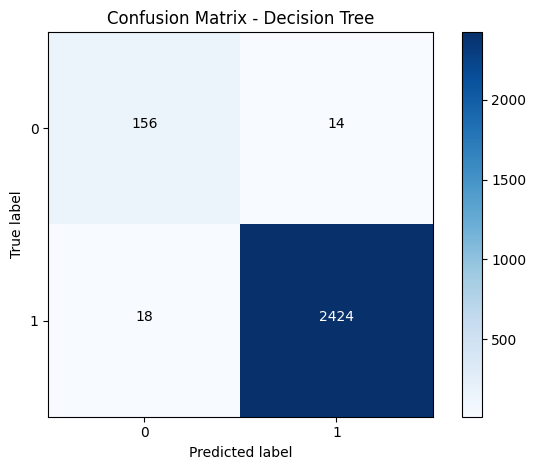

In [37]:
plot_confusion_matrix(confusion_matrix_dt, classes=[0, 1], title= "Confusion Matrix - Decision Tree")




In [38]:
# Plot confusion matrix for Random Forests

confusion_matrix_rf = confusion_matrix(test_Y, predictions_rf.round())
print("Confusion Matrix - Random Forest")
print(confusion_matrix_rf)


Confusion Matrix - Random Forest
[[ 153   17]
 [   7 2435]]


Confusion matrix, without normalization


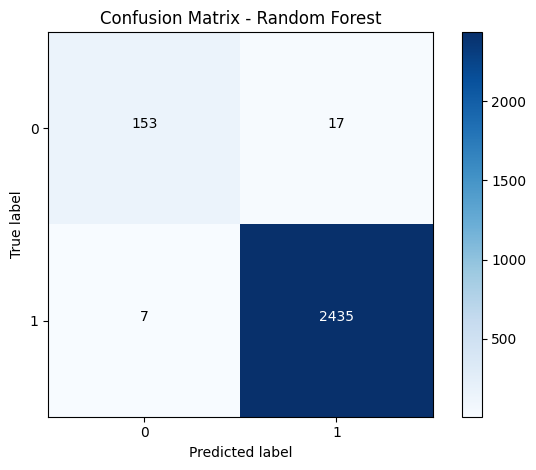

In [39]:
plot_confusion_matrix(confusion_matrix_rf, classes=[0, 1], title= "Confusion Matrix - Random Forest")



In [40]:
# The below function prints the following necesary metrics

def metrics(actuals, predictions):
    print("Accuracy: {:.5f}".format(accuracy_score(actuals, predictions)))
    print("Precision: {:.5f}".format(precision_score(actuals, predictions)))
    print("Recall: {:.5f}".format(recall_score(actuals, predictions)))
    print("F1-score: {:.5f}".format(f1_score(actuals, predictions)))

In [41]:
print("Evaluation of Decision Tree Model")
print()
metrics(test_Y, predictions_dt.round())


Evaluation of Decision Tree Model

Accuracy: 0.98775
Precision: 0.99426
Recall: 0.99263
F1-score: 0.99344


In [42]:
print("Evaluation of Random Forest Model")
print()
metrics(test_Y, predictions_rf.round())


Evaluation of Random Forest Model

Accuracy: 0.99081
Precision: 0.99307
Recall: 0.99713
F1-score: 0.99510


# Clearly, Random Forest model works better than Decision Trees

# But, if we clearly observe our dataset suffers a serious problem of **class imbalance**.
# The genuine (not fraud) transactions are more than 99% with the fraud transactions constituting of 0.17%.
#
# With such kind of distribution, if we train our model without taking care of the imbalance issues, it predicts the label with higher importance given to genuine transactions (as there are more data about them) and hence obtains more accuracy.

# The class imbalance problem can be solved by various techniques. **Over sampling** is one of them.
#
# One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model.
#
# Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the **Synthetic Minority Oversampling Technique**, or **SMOTE** for short.


In [44]:

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Assuming 'type', 'nameOrig', and 'nameDest' are the categorical columns
categorical_cols = ['type', 'nameOrig', 'nameDest']

# Fit the encoder to the categorical columns and transform them
for col in categorical_cols:
    # Convert the column to string type before encoding
    X[col] = X[col].astype(str)
    # Fit and transform the data
    X[col] = le.fit_transform(X[col])

# Now apply SMOTE
X_resampled, Y_resampled = SMOTE().fit_resample(X, Y)
print("Resampled shape of X: ", X_resampled.shape)
print("Resampled shape of Y: ", Y_resampled.shape)

value_counts = Counter(Y_resampled)
print(value_counts)

(train_X, test_X, train_Y, test_Y) = train_test_split(X_resampled, Y_resampled, test_size= 0.3, random_state= 42)


Resampled shape of X:  (16426, 10)
Resampled shape of Y:  (16426,)
Counter({0: 8213, 1: 8213})


In [45]:
# Build the Random Forest classifier on the new dataset

rf_resampled = RandomForestClassifier(n_estimators = 100)
rf_resampled.fit(train_X, train_Y)

predictions_resampled = rf_resampled.predict(test_X)
random_forest_score_resampled = rf_resampled.score(test_X, test_Y) * 100


In [46]:
# Visualize the confusion matrix

cm_resampled = confusion_matrix(test_Y,predictions_resampled.round() )
print("Confusion Matrix - Random Forest")
print(cm_resampled)

Confusion Matrix - Random Forest
[[2477    1]
 [   4 2446]]


Confusion matrix, without normalization


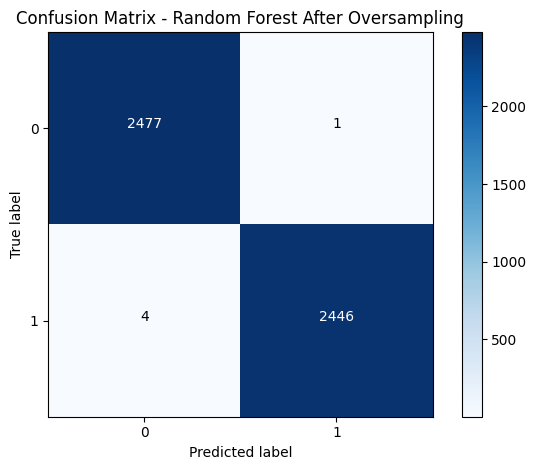

In [47]:
plot_confusion_matrix(cm_resampled, classes=[0, 1], title= "Confusion Matrix - Random Forest After Oversampling")


In [48]:
print("Evaluation of Random Forest Model")
print()
metrics(test_Y, predictions_resampled.round())


Evaluation of Random Forest Model

Accuracy: 0.99899
Precision: 0.99959
Recall: 0.99837
F1-score: 0.99898


  Model Training

Logistic Regression

In [49]:
model = LogisticRegression()

In [50]:
# training the Logistic Regression Model with Training Data
model.fit(train_X, train_Y)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Model Evaluation

Accuracy Score

In [51]:
# accuracy on training data
train_X_prediction = model.predict(train_X)
training_data_accuracy = accuracy_score(train_X_prediction, train_Y)

In [52]:
print('Accuracy on Training data : ', training_data_accuracy)

Accuracy on Training data :  0.9396416768133589


In [53]:
# accuracy on test data
X_test_prediction = model.predict(test_X)
test_data_accuracy = accuracy_score(X_test_prediction, test_Y)

In [54]:
print('Accuracy score on Test Data : ', test_data_accuracy)

Accuracy score on Test Data :  0.9472402597402597


In [55]:
classifier= LogisticRegression(random_state=0)
classifier.fit(train_X, train_Y)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [56]:
pred_Y= classifier.predict(test_X)

In [57]:

print(classification_report(test_Y, pred_Y))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2478
           1       0.97      0.92      0.95      2450

    accuracy                           0.95      4928
   macro avg       0.95      0.95      0.95      4928
weighted avg       0.95      0.95      0.95      4928



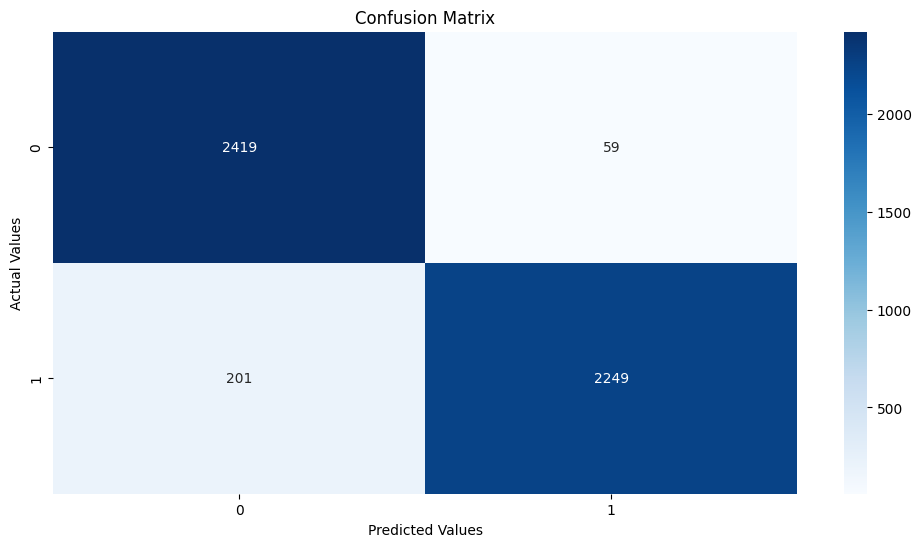

In [58]:
cm=confusion_matrix(test_Y,pred_Y)
plt.figure(figsize=(12,6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True,fmt='d', cmap='Blues')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.savefig('confusion_matrix.png')
